In [ ]:
import numpy as np
import random
# import sklearn.datasets as ds
from sklearn.utils import shuffle
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from keras.utils.np_utils import to_categorical
from matplotlib import image as img
import glob
import time
# from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.signal import fftconvolve as convolve
from scipy import signal
import pickle

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/My Drive/MNIST_Imbalanced_Dataset.zip"

Streaming output truncated to the last 5000 lines.
 extracting: train/9/1821.png        
 extracting: train/9/18212.png       
 extracting: train/9/18229.png       
  inflating: train/9/18242.png       
 extracting: train/9/18252.png       
 extracting: train/9/1827.png        
 extracting: train/9/18278.png       
 extracting: train/9/18297.png       
 extracting: train/9/18351.png       
 extracting: train/9/18356.png       
 extracting: train/9/18375.png       
 extracting: train/9/18378.png       
 extracting: train/9/18383.png       
 extracting: train/9/18388.png       
 extracting: train/9/184.png         
 extracting: train/9/18402.png       
 extracting: train/9/18406.png       
 extracting: train/9/18416.png       
 extracting: train/9/18438.png       
  inflating: train/9/18442.png       
 extracting: train/9/18449.png       
  inflating: train/9/18459.png       
 extracting: train/9/18476.png       
 extracting: train/9/18501.png       
 extracting: train/9/18507.png       

In [ ]:
def loadDataset(path):
    print('Loading Dataset...')
    train_x, train_y, test_x, test_y = [], [], [], []
    for i in range(10):
        for filename in glob.glob(path + 'train/' + str(i)+'/*.png'):
            im=img.imread(filename)
            train_x.append(im)
            train_y.append(i)
    for i in range(10):
        for filename in glob.glob(path + 'test/' + str(i)+'/*.png'):
            im=img.imread(filename)
            test_x.append(im)
            test_y.append(i)
    print('Dataset loaded...')
    return np.array(train_x), np.array(train_y),np.array(test_x),np.array(test_y)

In [ ]:
path='/content/'
train_set_x, train_set_y, test_set_x, test_set_y =loadDataset(path)

Loading Dataset...
Dataset loaded...


In [ ]:
def one_hot_encoding(x):
        out=(np.arange(10)==x)
        out=out.astype('int')
        return out

In [ ]:
def data_preprocessing(train_x, test_x, train_y, test_y):
    train_set_yy=train_y.reshape(-1,1)
    test_set_yy=test_y.reshape(-1,1)     

    mean = train_x.mean(axis=0)
    plt.imshow(mean)

    train_set_x = train_x -mean
    test_set_x = test_x-mean
    train_set_xx=np.expand_dims(train_set_x, axis=3)
    test_set_xx=np.expand_dims(test_set_x, axis=3)

    train_set_x, val_set_x, train_set_y, val_set_y = train_test_split(train_set_xx, train_set_yy, test_size=0.10, random_state=42, stratify = train_set_yy)
    
    print("Training Data_X size : ",train_set_x.shape)
    print("Training Data_Y size : ",train_set_y.shape)
    print("Validation DataX : ",val_set_x.shape)
    print("Validation DataY : ",val_set_y.shape)
    print("Testing Data_X size : ",test_set_xx.shape)
    print("Testing Data_y size : ",test_set_yy.shape)
    return train_set_x,val_set_x,test_set_xx,train_set_y,val_set_y,test_set_yy

Training Data_X size :  (39123, 28, 28, 1)
Training Data_Y size :  (39123, 1)
Validation DataX :  (4347, 28, 28, 1)
Validation DataY :  (4347, 1)
Testing Data_X size :  (10000, 28, 28, 1)
Testing Data_y size :  (10000, 1)


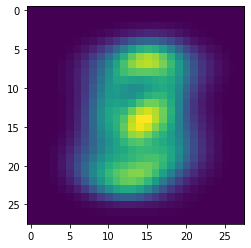

In [ ]:
train_set_x,val_set_x,test_set_x,train_set_y,val_set_y,test_set_y=data_preprocessing(train_set_x, test_set_x,train_set_y, test_set_y)

In [ ]:
# train_set_y=train_set_y.reshape(-1,1)
# test_set_y=test_set_y.reshape(-1,1)

In [ ]:
train_set_y=one_hot_encoding(train_set_y)
test_set_y=one_hot_encoding(test_set_y)
val_set_y=one_hot_encoding(val_set_y)
print("Training Data_Y size : ",train_set_y.shape)
print("Validation DataX : ",val_set_y.shape)
print("Testing Data_y size : ",test_set_y.shape)

Training Data_Y size :  (39123, 10)
Validation DataX :  (4347, 10)
Testing Data_y size :  (10000, 10)


In [ ]:
class DeepNeuralNetwork():
    def __init__(self, no_of_layers,input_dim,neurons_per_layer, epochs, l_rate):
        self.no_of_layers = no_of_layers
        self.input_dim=input_dim
        self.neurons_per_layer = neurons_per_layer
        self.epochs = epochs
        self.l_rate = l_rate
        self.params = self.initialization()
        self.visualization_data= {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    
    def ReLu(self, x, derivative=False):
        if derivative:
            return np.array(x, copy=True)
        return np.maximum(0,x)

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)
    def sigmoid(self, x, derivative=False):
        if derivative:
            y=1/(1+np.exp(-x))
            return y*(1-y)
        return 1/(1 + np.exp(-x))

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.input_dim
        hidden_1=self.neurons_per_layer[0]
        output_layer=self.neurons_per_layer[1]

        self.params = {
            # 'W1':np.array([0.01,0.01,-0.01,-0.01]).reshape(1,4)}
            'W1':np.random.randn(hidden_1, input_layer) * 0.01,
            'W2':np.random.randn(output_layer, hidden_1) * 0.01}

        return self.params

    def forward_pass(self, x_train):
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        self.params['Z1'] = np.dot(params["W1"], params['A0'].T)
        params['A1'] = self.ReLu(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.softmax(params['Z2'])
        return params['A2']

    def backward_pass(self, y_train, output):
      change_w = {}
      change_A = {}
      epsilon=0.0000001

      dZ2 = (np.divide((1-y_train+ epsilon),( 1- self.params['A2'])) - np.divide(y_train+ epsilon, self.params['A2'])) * self.softmax(self.params['Z2'], derivative=True)
    
      dW2 = np.dot(dZ2, self.params['A1'].T)
      dA1 = np.dot(self.params['W2'].T, dZ2)

      dZ1 = dA1 * self.ReLu(self.params['Z1'], derivative=True)
      dW1 = np.dot(dZ1, self.params['A0'])
      dA0=np.dot(dZ1.T,self.params['W1'])
      change_w['W2']=dW2
      change_w['W1']=dW1
      change_A['A1']=dA1
      change_A['A0']=dA0

      return change_w,change_A
    
    def crossentropy(self, Y, Y_pred):
        m=Y.shape[0]
        epsilon=0.00000001
        logprobs = np.multiply(np.log(Y_pred+epsilon),Y)+np.multiply((1-Y),np.log(1-Y_pred+epsilon))
        cost = -(1/m)*np.sum(logprobs)
        return  cost
    
    def filters_initial(self,size,numbers):
        filters= np.random.normal(0,1,(numbers,size,size,1))
        print("Filter's size",filters.shape)
        return filters
    
    def create_mask_from_window(self,x):

    
        mask = x == np.max(x)

        return mask
    
    def conv_forward(self,A_prev, W):

        (m, n_H_prev, n_W_prev,n_C_prev) = A_prev.shape
        (n_C,f, f, n_C_prev) = W.shape

        stride=1
        pad=0
        n_H = int((n_H_prev + 2*pad - f)/stride) + 1
        n_W =int((n_W_prev + 2*pad - f)/stride) + 1

        Z = np.zeros([m, n_H, n_W, n_C])
        A_prev_pad = A_prev

        for i in range(m):                              
            a_prev_pad = A_prev_pad[i,:,:,:]                           
            for c in range(n_C):  
              Z[i, :, :,c] = convolve(a_prev_pad,W[c, :, :, :], mode='valid').reshape(n_H,n_W)

        assert(Z.shape == (m, n_H, n_W, n_C))
        cache = (A_prev, W)

        return Z, cache

    def pool_forward(self,A_prev, mode = "max"):
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

        f = 2
        stride = 2

        n_H = int(1 + (n_H_prev - f) / stride)
        n_W = int(1 + (n_W_prev - f) / stride)
        n_C = n_C_prev
        A = np.zeros((m, n_H, n_W, n_C))              


        for i in range(m):                        
            for h in range(n_H):                     
                for w in range(n_W):                 
                    for c in range (n_C):           
                        vert_start = h*stride
                        vert_end = h*stride +f
                        horiz_start = w*stride
                        horiz_end = w*stride + f

                        a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end,c]

                        if mode == "max":
                            A[i, h, w, c] = np.max(a_prev_slice)

        cache = (A_prev)
        assert(A.shape == (m, n_H, n_W, n_C))

        return A, cache
    
    def conv_backward(self,dZ, cache):
        (A_prev, W) = cache

        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
        A_prev=A_prev.reshape(m,n_C_prev,n_H_prev,n_W_prev)
        (n_C,f, f, n_C_prev) = W.shape
        W=W.reshape(n_C,n_C_prev,f,f)
        stride = 1
        pad = 0

        (m, n_H, n_W, n_C) = dZ.shape
        dZ=dZ.reshape(m,n_C,n_H,n_W)

        dA_prev = np.zeros((m, n_C_prev,n_H_prev, n_W_prev))                           
        dW = np.zeros((n_C, n_C_prev,f, f))
        db = np.zeros((1, 1, 1, n_C))

        A_prev_pad = A_prev
        delta_after_pad =dA_prev
        for i in range(m):
            batch_slice = A_prev_pad[i, :, :, :]
            for f in range(n_C):
                delta_rotate = np.rot90(dZ[i,f,:,:], 2)
                for channel in range(n_C_prev):
                    dW[f,channel,:,:] += signal.convolve2d(delta_rotate, batch_slice[channel], mode = 'valid')
                    w_rotate = np.rot90(W[f,channel,:,:], 2)
                    dA_prev[i, channel]= signal.convolve2d(w_rotate, dZ[i,f], mode = 'full')


        dA_prev = dA_prev.reshape(m,n_H_prev, n_W_prev, n_C_prev) 
        assert(dA_prev.shape == (m, n_H_prev, n_W_prev,n_C_prev))

        return dA_prev, dW


    def pool_backward(self,dA, cache, mode = "max"):

        A_prev = cache
        stride = 2
        f = 2

        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        m, n_H, n_W, n_C = dA.shape
        dA_prev = np.zeros(A_prev.shape)

        for i in range(m): 
            a_prev = A_prev[i]
            for h in range(n_H):                  
                for w in range(n_W):               
                    for c in range(n_C):         
                        vert_start = h*stride
                        vert_end = h*stride + f
                        horiz_start = w*stride
                        horiz_end = w*stride + f

    
                        if mode == "max":
                            a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                            mask = self.create_mask_from_window(a_prev_slice)
                            dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
        assert(dA_prev.shape == A_prev.shape)

        return dA_prev
    
    def update_network_parameters(self, changes_to_w,filters,dW):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value
        filters-=(self.l_rate*dW)
        return filters
        
    def compute_accuracy(self, output, y_train):
        predictions = []

        for x, y in zip(output, y_train):
            # print("acc_X_shape",x.shape)
            pred = np.argmax(x)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)
    
    def train(self, x_train, y_train,x_val,y_val,x_test,y_test):
        start_time = time.time()
        filters= self.filters_initial(17,36)
        for iteration in range(self.epochs):
            print("Forward Convolution...")
            a,b=self.conv_forward(x_train,filters)
            print("Forward Pooling...")
            pooling,c=self.pool_forward(a)
            relu=self.ReLu(pooling,derivative=False)
            X=relu.reshape(relu.shape[0],-1)
            print("NN forward...")
            output = self.forward_pass(X)
            cost = self.crossentropy(y_train,output.T)
            print("Back Propagation... ")
            changes_to_w,changes_to_A = self.backward_pass(y_train.T, output)
            self.ReLu(changes_to_A['A0'],derivative=True)
            dA=changes_to_A['A0'].reshape(x_train.shape[0],6,6,36)
            print("backward Pooling...")
            d_pool=self.pool_backward(dA,a)
            print("backward Convolution...")
            dA,dW=self.conv_backward(d_pool,b)
            dW=dW.reshape(36,17,17,1)
            self.params['W1']=self.params['W1']-self.l_rate*changes_to_w['W1']
            self.params['W2']=self.params['W2']-self.l_rate*changes_to_w['W2']
            filters=filters-(self.l_rate*dW)
            accuracy=self.compute_accuracy(output.T,y_train)*100
            print("Validation...")
            print("Forward Convolution...")
            a_val,b_val=self.conv_forward(x_val,filters)
            print("Forward Pooling...")
            pooling_val,c_val=self.pool_forward(a_val)
            relu_val=self.ReLu(pooling_val,derivative=False)
            X=relu_val.reshape(relu_val.shape[0],-1)
            print("NN forward...")
            output_val= self.forward_pass(X)
            cost_val = self.crossentropy(y_val,output_val.T)
            accuracy_val=self.compute_accuracy(output_val.T,y_val)*100
            # print("epoch :  {}, training_loss:  {}% ,training_accuracy : {}% ".format(iteration,cost,accuracy))
            print("epoch :  {}, training_loss:  {}% ,training_accuracy : {}%, val_loss : {}%, val_accuracy : {}% ".format(iteration,cost,accuracy,cost_val,accuracy_val))
            self.visualization_data['training_loss'].append(cost)
            self.visualization_data['validation_loss'].append(cost_val)
            self.visualization_data['training_accuracy'].append(accuracy)
            self.visualization_data['validation_accuracy'].append(accuracy_val)

        print("Testing...")
        print("Forward Convolution...")
        a_test,b_test=self.conv_forward(x_test,filters)
        print("Forward Pooling...")
        pooling_test,c_test=self.pool_forward(a_test)
        relu_test=self.ReLu(pooling_test,derivative=False)
        X_testt=relu_test.reshape(relu_test.shape[0],-1)
        print("NN forward...")
        output_test= self.forward_pass(X_testt)
        cost_test = self.crossentropy(y_test,output_test.T)
        accuracy_test=self.compute_accuracy(output_test.T,y_test)*100
        print("Accuracy on Testing data : ",accuracy_test,"%")
        
        return output,self.visualization_data,output_test,cost_test
    def saveModel(self,name):
        # save your trained model, it is your interpretation how, which and what data you store
        # which you will use later for prediction 

        with open(name, 'wb') as file:  
            pickle.dump(self, file)

        
    def loadModel(self,name):
        # load your trained model, load exactly how you stored it.
        with open(name, 'rb') as file:  
            Model = pickle.load(file)

        return Model
    def visualization(self,visualization_data):
        fig, ax = plt.subplots(1, 2, figsize=(25, 5))

        ax[0].plot(visualization_data['training_accuracy'], label='Training dataset Accuracy')
        ax[0].plot(visualization_data['validation_accuracy'], label='Validation dataset Accuracy')

        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Accuracy')
        ax[0].set_title('Training and Validation datset Accuracy Graph')
        ax[0].legend()

        ax[1].plot(visualization_data['training_loss'], label='Training dataset Loss')
        ax[1].plot(visualization_data['validation_loss'], label='Validation dataset Loss')

        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Cross Entropy Loss')
        ax[1].set_title('Training and Validation dataset Losses Graph')
        ax[1].legend()
        plt.show()

In [ ]:
    def main(no_of_layers,input_size,no_neurons,trainX,trainY,validX,validY,testX,testY,learningrate,load_model,epochs):
        print("Training DataX size : ",trainX.shape)
        print("Training DataY size : ",trainY.shape)
        print("Validation DataX size : ",validX.shape)
        print("Validation DataY size : ",validY.shape)
        print("Testing Data size : ",testX.shape)
        print("Testing Data size : ",testY.shape)
        model = DeepNeuralNetwork(no_of_layers,input_size,no_neurons,epochs,learningrate)
        if load_model==False :
            pred,visual,Out_t,cost_t=model.train(trainX, trainY, validX, validY,testX,testY)
            model.saveModel('bestmodel.mdl')
            model.visualization(visual)
        else :
            mm=model.loadModel('bestmodel.mdl')
            print("Testing data Accuracy : ",model.accuracy(testX,testY))
            mm.visualization(visual)
        return pred,visual,Out_t,cost_t

Training DataX size :  (39123, 28, 28, 1)
Training DataY size :  (39123, 10)
Validation DataX size :  (4347, 28, 28, 1)
Validation DataY size :  (4347, 10)
Testing Data size :  (10000, 28, 28, 1)
Testing Data size :  (10000, 10)
Filter's size (36, 17, 17, 1)
Forward Convolution...
Forward Pooling...
NN forward...
Back Propagation... 
backward Pooling...
backward Convolution...
Validation...
Forward Convolution...
Forward Pooling...
NN forward...
epoch :  0, training_loss:  3.2565320720175746% ,training_accuracy : 6.8092937658155055%, val_loss : 3.2398824481689323%, val_accuracy : 9.77685760294456% 
Forward Convolution...
Forward Pooling...
NN forward...
Back Propagation... 
backward Pooling...
backward Convolution...
Validation...
Forward Convolution...
Forward Pooling...
NN forward...
epoch :  1, training_loss:  3.2410947711927944% ,training_accuracy : 9.628607213148275%, val_loss : 3.224298263621852%, val_accuracy : 11.755233494363928% 
Forward Convolution...
Forward Pooling...
NN fo

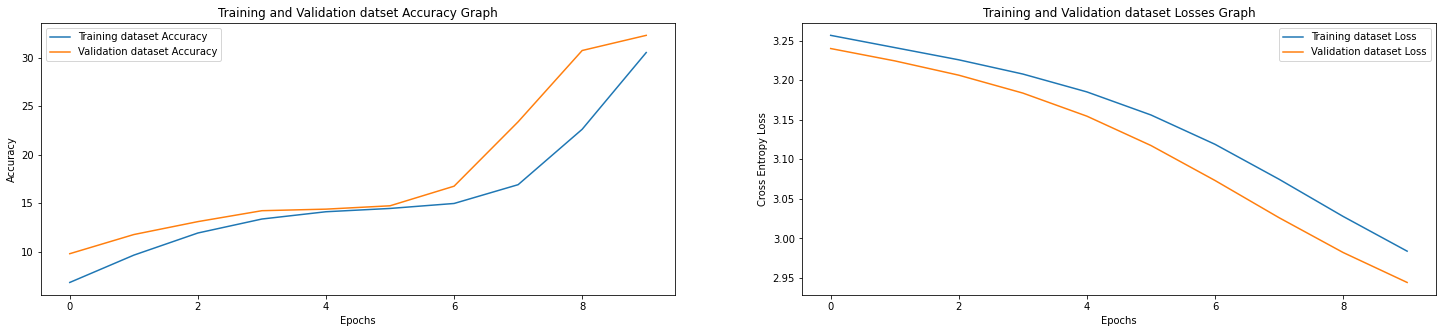

In [ ]:
no_of_layers=2
input_size=1296
no_neurons=[30,10]
load_model=False
learningrate=0.0000001
epochs=10
pred,visual,Out_t,cost_t=main(no_of_layers,input_size,no_neurons,train_set_x,train_set_y,val_set_x,val_set_y,test_set_x,test_set_y,learningrate,load_model,epochs)
 